In [1]:
# FIRSTLY, CHECK VERSION OF SPECTRAL-CUBE

import spectral_cube
print('spectral_cube: '+str(spectral_cube.__version__)) 
#default spectral-cube installation is ver 0.5.0 --> update to ver 0.6.0 before running!

spectral_cube: 0.6.0


In [2]:
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, PathFromCenter
from astropy.coordinates import SkyCoord

In [3]:
# SILENCES WARNING ABOUT SPECTRAL CUBE READING IN DATA WITH A STOKES AXIS
import warnings
from spectral_cube.utils import StokesWarning
warnings.filterwarnings(action='ignore', category=StokesWarning, append=True)

In [4]:
# FIGURE MANAGEMENT
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rc("savefig", dpi=100)
plt.rcParams['figure.facecolor']='w'

In [5]:
# READ IN EXAMPLE FITS CUBE: https://almascience.eso.org/dataPortal/member.uid___A001_X1354_X1b8.CB68_sci.spw29.cube.I.pbcor.fits
# WHICH IS PROTOSTELLAR SOURCE IRAS 16544-1604

filename = 'member.uid___A001_X1354_X1b8.CB68_sci.spw29.cube.I.pbcor.fits'
hdu = fits.open(filename)[0]
data = hdu.data
slice_tot = data.shape[1] #get number of slices in cube
wcs = WCS(hdu.header)
print(wcs)

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 254.3318458333  -16.15664444444  244902480118.0  1.0  
CRPIX : 101.0  101.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -5.555555555556e-05  5.555555555556e-05  122072.1999817  1.0  
NAXIS : 200  200  476  1


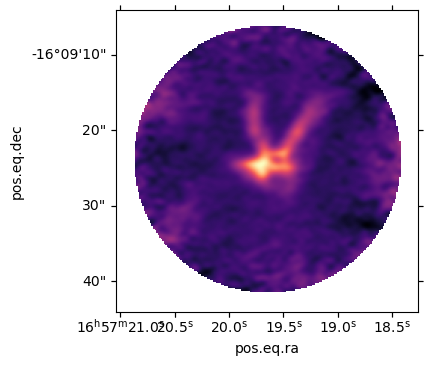

In [6]:
# PLOT SLICE OF CUBE TO VISUALIZE 
slice_num = 238 #play around with slice_num until significant features are visible

fig = plt.figure()
ax = plt.subplot(projection=wcs, slices=('x', 'y', slice_num, 0)) 
ax.imshow(data[0,slice_num,:,:], cmap='magma')
plt.show()

In [7]:
# PLOT PATH OF OUTFLOW 

#ICRS coordinates for IRAS 16544-1604 from SIMBAD
star_ra = "16h 57m 19.626s"
star_dec = "-16d 09m 23.30s"

#P.A. = 142 deg (Wu et al. 1996; Vallée et al. 2000)
outflow = PathFromCenter(center=SkyCoord(ra=star_ra, dec=star_dec, frame='icrs'), \
                        length=25.0 * u.arcsec, angle=142 * u.deg, width=7)

In [8]:
# STOKES AND SPECTRAL AXIS MUST BE DROPPED TO CONVERT BTWN PIXEL AND WORLD COORDINATES 
wcs_3d = wcs.dropaxis(-1)
wcs_2d = wcs_3d.dropaxis(-1)
print(wcs_2d)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 254.3318458333  -16.15664444444  
CRPIX : 101.0  101.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-05  5.555555555556e-05  
NAXIS : 200  200


In [9]:
# CREATE ARRAYS OF SAMPLE POINTS ALONG THE OUTFLOW CONVERTED TO WORLD COORDINATES
outflow_coords = np.array(outflow.get_xy(wcs))
sample_pts = np.array(outflow.sample_points(1,wcs))

center_RA, center_Dec = wcs_2d.wcs_pix2world(sample_pts[0], sample_pts[1], 1)
outflow_x, outflow_y = outflow_coords.T 

In [10]:
# CONVERT SPECTRAL AXIS FROM FREQUENCY TO VELOCITY 

rest_freq = hdu.header['RESTFRQ'] #get rest frequency from file header
cube_freq = SpectralCube.read(filename)
cube_vel = cube_freq.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest_freq * u.Hz)
print(cube_vel)

SpectralCube with shape=(476, 200, 200) and unit=Jy / beam:
 n_x:    200  type_x: RA---SIN  unit_x: deg    range:   254.326120 deg:  254.337630 deg
 n_y:    200  type_y: DEC--SIN  unit_y: deg    range:   -16.162200 deg:  -16.151144 deg
 n_s:    476  type_s: VRAD      unit_s: km / s  range:      -30.486 km / s:      40.485 km / s


In [11]:
#CREATE ARRAYS OF SAMPLE POINTS ALONG AXIS PERPENDICULAR TO THE OUTFLOW 

distance = 50 #arbitrary index along outflow axis; can adjust for PV slicing after visualization in the next cell
path = PathFromCenter(center=SkyCoord(ra=center_RA[distance] * u.deg, dec=center_Dec[distance] * u.deg, frame='icrs'), \
                      length=20.0 * u.arcsec, angle=232 * u.deg, width=7) 
path_coords = np.array(path.get_xy(wcs))
path_x, path_y = path_coords.T

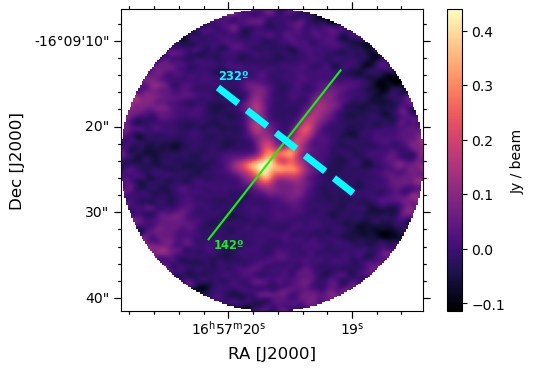

In [12]:
# PLOT VISUALIZATION OF OUTFLOW AND PERPENDICULAR AXIS --> CHANGE "distance" TO ADJUST WHERE PV SLICE GOES

fig = plt.figure()
ax = pl.subplot(111, projection=wcs, slices=('x', 'y', slice_num, 0))
im = ax.imshow(cube_vel[slice_num].value, cmap='magma')

cb = plt.colorbar(mappable=im)
cb.set_label(cube_vel.unit)

ax0 = ax.coords[0]
ax0.set_ticks(number=3, size=5)
ax0.display_minor_ticks(True)
ax.set_xlabel('RA [J2000]', size=12)

ax1 = ax.coords[1]
ax1.set_ticks(number=5, size=5)
ax1.display_minor_ticks(True)
ax.set_ylabel('Dec [J2000]', size=12)

ax.plot(outflow_x,outflow_y, color='lime', ls='-')
ax.annotate("142º", (outflow_x[1]+3,outflow_y[1]-5), c='lime', fontsize='small', fontweight='bold')
    
ax.plot(path_x, path_y, color='cyan', ls='--', linewidth=5) 
ax.annotate("232º", (path_x[0],path_y[0]+5), c='cyan', fontsize='small', fontweight='bold')

#zoom window fitted to data
bound = np.argwhere(~np.isnan(cube_vel[slice_num].value)) 
plt.xlim(min(bound[:,1]), max(bound[:,1]))
plt.ylim(min(bound[:,0]), max(bound[:,0]))

plt.show()

In [13]:
# EXTRACT PV SLICE
pvdiagram = extract_pv_slice(cube=cube_vel, path=path, spacing=1)
ww = WCS(pvdiagram.header)
pv_data = pvdiagram.data
print(ww)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VRAD'  
CRVAL : 0.0  40484.933585024  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 5.555555555556e-05  -149.41205488585  
NAXIS : 99  476


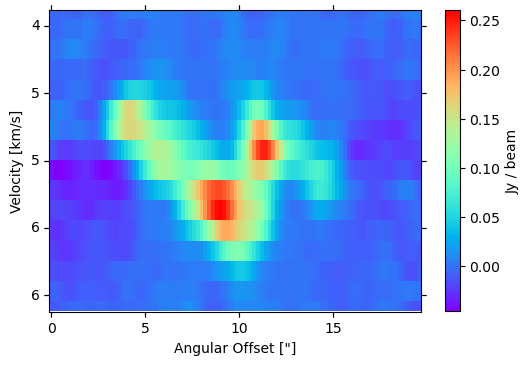

In [14]:
# PLOT POSITION-VELOCITY DIAGRAM

fig = plt.figure()
ax = plt.subplot(111, projection=ww)
im = ax.imshow(pv_data, cmap='rainbow', origin='lower', aspect='auto') 
#imshow's "extent" argument doesn't work properly to zoom in --> "plt.ylim" as crude workaround

cb = plt.colorbar(mappable=im)
cb.set_label(cube_vel.unit)

ax0 = ax.coords[0] 
ax0.set_format_unit(u.arcsec) #convert from default unit of deg
ax0.set_major_formatter('x') #integer labels
ax0.set_auto_axislabel(False)
ax.set_xlabel('Angular Offset ["]')

ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s) #convert from default unit of m/s
ax.set_ylabel('Velocity [km/s]')

plt.ylim(230,245) #play around with pixel coordinates to zoom in on feature
plt.show()

##### 